<a href="https://colab.research.google.com/github/RafaelSdeSouza/astrostats-2025/blob/main/CNN_Galaxy_zoo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Step 0: Install required libs
!pip install tensorflow matplotlib scikit-learn pillow

# Step 1: Imports
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, Model
from sklearn.manifold import TSNE
from PIL import Image

In [3]:
import tensorflow as tf
# List physical devices
print("TF Version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

TF Version: 2.18.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
# Descompacta o dataset.zip na raiz
!unzip -q dataset.zip
!ls dataset/train

unzip:  cannot find or open dataset.zip, dataset.zip.zip or dataset.zip.ZIP.
ls: cannot access 'dataset/train': No such file or directory


Found 2419 images belonging to 2 classes.
Found 2109 images belonging to 2 classes.


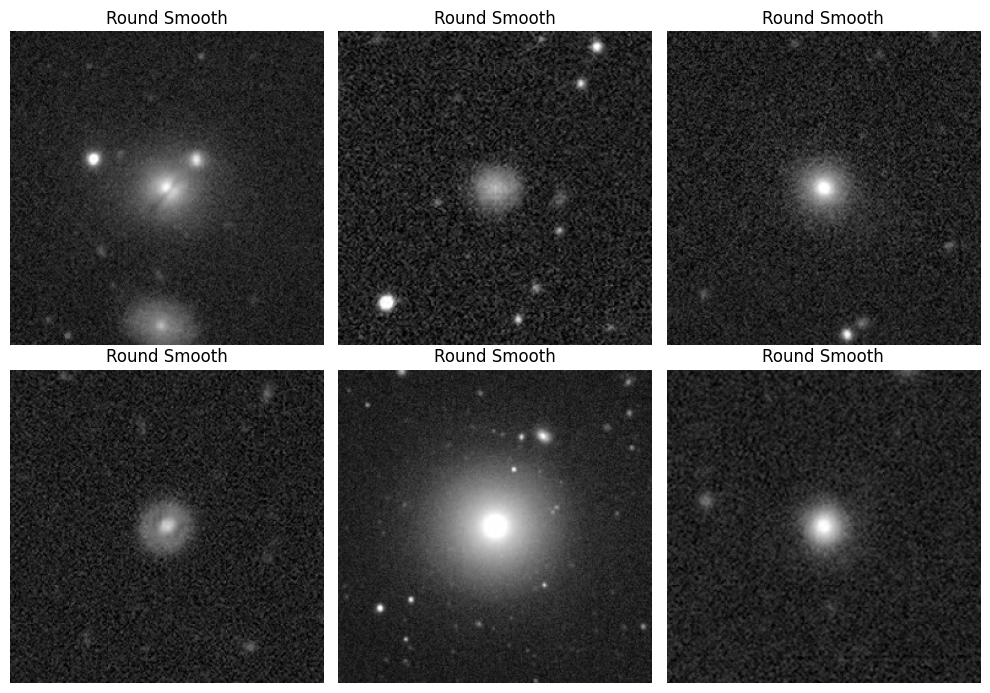

In [3]:
# Step 2: Setup data generators
img_size = (256, 256)
batch_size = 128

train_gen = ImageDataGenerator(rescale=1/255)
val_gen = ImageDataGenerator(rescale=1/255)

train_data = train_gen.flow_from_directory("/content/drive/MyDrive/dataset/train", target_size=img_size,
                                           batch_size=batch_size, class_mode='binary')
val_data = val_gen.flow_from_directory("/content/drive/MyDrive/dataset/val", target_size=img_size,
                                       batch_size=batch_size, class_mode='binary')

# Step 3: Visualize sample images
batch = next(train_data)
fig, axes = plt.subplots(2, 3, figsize=(10, 7))
for i, ax in enumerate(axes.flat):
    ax.imshow(batch[0][i])
    label = "Round Smooth" if batch[1][i] == 0 else "Barred Spiral"
    ax.set_title(label)
    ax.axis("off")
plt.tight_layout()
plt.show()

In [4]:
# Step 4: Define simple CNN
input_layer = layers.Input(shape=(256, 256, 3))
x = layers.Conv2D(32, 3, activation='relu', name="conv1")(input_layer)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(64, 3, activation='relu', name="conv2")(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu', name="latent")(x)
output = layers.Dense(1, activation='sigmoid', name="classifier")(x)

# Nova seção

In [ ]:
model = Model(inputs=input_layer, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Step 5: Train model
model.fit(train_data, steps_per_epoch=len(train_data),
          epochs=1, validation_data=val_data,
          validation_steps=len(val_data))

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/3
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - accuracy: 0.9911 - loss: 0.1291 

In [ ]:
# Step 6: Visualize first-layer activations
activation_model = Model(inputs=model.input, outputs=model.get_layer("conv1").output)
activations = activation_model.predict(batch[0][0:1])  # only first image

In [ ]:
fig, axes = plt.subplots(1, 6, figsize=(15, 5))
for i in range(6):
    axes[i].imshow(activations[0, :, :, i], cmap='viridis')
    axes[i].axis('off')
    axes[i].set_title(f'Filter {i+1}')
plt.suptitle("First Conv Layer Activations")
plt.tight_layout()
plt.show()

# Step 7: Latent space projection (t-SNE)
latent_model = Model(inputs=model.input, outputs=model.get_layer("latent").output)
features = latent_model.predict(batch[0])
tsne = TSNE(n_components=2, perplexity=5, random_state=42)
proj = tsne.fit_transform(features)

plt.figure(figsize=(8,6))
plt.scatter(proj[:, 0], proj[:, 1], c=batch[1], cmap='coolwarm', s=50)
plt.title("Latent Space (t-SNE)")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.grid(True)
plt.show()